<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>

## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the *k*-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
!pip install geopy

     |████████████████████████████████| 112kB 6.4MB/s eta 0:00:01


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [5]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [6]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [7]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [9]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [13]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [14]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [15]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [16]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [17]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [1]:
# Left empty for confidentiality reasons
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [19]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [20]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [21]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL




'https://api.foursquare.com/v2/venues/explore?&client_id=L3IGVA3DHJNIKJDO50XKKWCD5IWWWZLVYX0VYYM4NPF3G0RB&client_secret=AMRQXBPNVYGDDVZSLDWWHJOSDATGFGRQXICOQY330RI0HR30&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Double-click __here__ for the solution.
<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 

Send the GET request and examine the resutls

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f17220ef5887b50519f1c7c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Astral Fitness & Wellness Center,Gym,40.876705,-73.906372


And how many venues were returned by Foursquare?

In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


<a id='item2'></a>

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [27]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [28]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3183, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym


Let's check how many venues were returned for each neighborhood

In [29]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,68,68,68,68,68,68
Carnegie Hill,95,95,95,95,95,95
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,45,45,45,45,45,45
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 331 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [31]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,S

And let's examine the new dataframe size.

In [32]:
manhattan_onehot.shape

(3183, 332)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,S

#### Let's confirm the new size

In [34]:
manhattan_grouped.shape

(40, 332)

#### Let's print each neighborhood along with the top 5 most common venues

In [35]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.09
1          Hotel  0.07
2            Gym  0.06
3    Coffee Shop  0.06
4  Memorial Site  0.04


----Carnegie Hill----
               venue  freq
0        Coffee Shop  0.07
1               Café  0.05
2        Pizza Place  0.04
3        Yoga Studio  0.03
4  French Restaurant  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1  American Restaurant  0.04
2                  Bar  0.04
3   Seafood Restaurant  0.04
4       Cosmetics Shop  0.04


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.05
2  American Restaurant  0.04
3   Italian Restaurant  0.03
4   Seafood Restaurant  0.03


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1                 Bakery  0.05
2           Cocktail Bar  0.05
3  Vietnamese Restaurant  0.03
4        Bubble Tea Shop  0.03


----Civic Center----
                  venue  freq


#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Playground,Plaza,Shopping Mall,Gourmet Shop,BBQ Joint
1,Carnegie Hill,Coffee Shop,Café,Pizza Place,Yoga Studio,Bookstore,Bakery,French Restaurant,Japanese Restaurant,Italian Restaurant,Bar
2,Central Harlem,African Restaurant,Seafood Restaurant,Bar,American Restaurant,Chinese Restaurant,French Restaurant,Cosmetics Shop,Market,Caribbean Restaurant,Library
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Bakery,Seafood Restaurant,French Restaurant,Market,Hotel,Pizza Place
4,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Salon / Barbershop,Vietnamese Restaurant,Spa,Bubble Tea Shop,Hotpot Restaurant,Ice Cream Shop,Dessert Shop


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [38]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 4, 1, 4, 0, 1, 4, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Gym,Coffee Shop,Yoga Studio,Diner,Seafood Restaurant,Sandwich Place,Supplement Shop,Tennis Stadium,Donut Shop,Shopping Mall
1,Manhattan,Chinatown,40.715618,-73.994279,4,Chinese Restaurant,Cocktail Bar,Bakery,Salon / Barbershop,Vietnamese Restaurant,Spa,Bubble Tea Shop,Hotpot Restaurant,Ice Cream Shop,Dessert Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Mobile Phone Shop,Chinese Restaurant,Seafood Restaurant,Bank,Tapas Restaurant,Mexican Restaurant,Coffee Shop,Italian Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop,Bakery,Spanish Restaurant,Chinese Restaurant,Caribbean Restaurant,American Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Bakery,Park,Cocktail Bar,Sandwich Place,Chinese Restaurant


Finally, let's visualize the resulting clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [133]:
cluster_1_df = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Roosevelt Island,Park,Hotel,School,Gym,Coffee Shop,Greek Restaurant,Dry Cleaner,Sandwich Place,Liquor Store,Noodle House
13,Lincoln Square,Café,Gym / Fitness Center,Plaza,Theater,Concert Hall,Performing Arts Venue,Wine Shop,American Restaurant,Italian Restaurant,Coffee Shop
21,Tribeca,Park,Italian Restaurant,Café,American Restaurant,Wine Bar,Spa,Coffee Shop,Skate Park,Hotel,Greek Restaurant
24,West Village,Italian Restaurant,New American Restaurant,American Restaurant,Park,Cocktail Bar,French Restaurant,Jazz Club,Coffee Shop,Wine Bar,Theater
28,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Playground,Plaza,Shopping Mall,Gourmet Shop,BBQ Joint
32,Civic Center,Coffee Shop,Cocktail Bar,Hotel,Gym / Fitness Center,Spa,Yoga Studio,Café,French Restaurant,Italian Restaurant,Bakery
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Burger Joint,Cosmetics Shop,Gym / Fitness Center,Clothing Store,Coffee Shop,Bakery,Pizza Place
34,Sutton Place,Italian Restaurant,Gym / Fitness Center,Furniture / Home Store,Park,Coffee Shop,Gym,Bakery,Thai Restaurant,Beer Bar,Spa
35,Turtle Bay,Coffee Shop,Sushi Restaurant,Italian Restaurant,Wine Bar,Park,Seafood Restaurant,Café,Japanese Restaurant,Deli / Bodega,French Restaurant
39,Hudson Yards,Gym / Fitness Center,Hotel,American Restaurant,Café,Italian Restaurant,Burger Joint,Dog Run,Gym,Park,Coffee Shop


#### Cluster 2

In [132]:
cluster_2_df = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Bakery,Coffee Shop,Gym / Fitness Center,Yoga Studio,Spa,French Restaurant,Juice Bar,Exhibit,Pizza Place
9,Yorkville,Italian Restaurant,Coffee Shop,Bar,Gym,Sushi Restaurant,Deli / Bodega,Mexican Restaurant,Wine Shop,Pizza Place,Japanese Restaurant
10,Lenox Hill,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Café,Cocktail Bar,Gym / Fitness Center,Gym,Burger Joint,Deli / Bodega
12,Upper West Side,Italian Restaurant,Bar,Wine Bar,Coffee Shop,Mediterranean Restaurant,Bakery,Thai Restaurant,Indian Restaurant,Ice Cream Shop,Middle Eastern Restaurant
14,Clinton,Italian Restaurant,Theater,Gym / Fitness Center,Wine Shop,American Restaurant,Coffee Shop,Sandwich Place,Cocktail Bar,Gym,Hotel
15,Midtown,Coffee Shop,Clothing Store,Hotel,Bakery,Theater,Steakhouse,Bookstore,Pizza Place,Sporting Goods Shop,Japanese Restaurant
16,Murray Hill,Sandwich Place,Japanese Restaurant,Coffee Shop,Burger Joint,Mediterranean Restaurant,Pizza Place,Hotel,American Restaurant,Gym / Fitness Center,Steakhouse
17,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Italian Restaurant,Bakery,Seafood Restaurant,French Restaurant,Market,Hotel,Pizza Place
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Café,Ice Cream Shop,American Restaurant,Indian Restaurant,French Restaurant,Gym,Coffee Shop,Clothing Store
19,East Village,Bar,Ice Cream Shop,Pizza Place,Mexican Restaurant,Cocktail Bar,Korean Restaurant,Dessert Shop,Wine Bar,Italian Restaurant,Vietnamese Restaurant


#### Cluster 3

In [131]:
cluster_3_df = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Playground,Heliport,Fountain,Farmers Market,Skating Rink,Bistro,Gas Station,Baseball Field,Gym / Fitness Center


#### Cluster 4

In [130]:
cluster_4_df = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Gym,Coffee Shop,Yoga Studio,Diner,Seafood Restaurant,Sandwich Place,Supplement Shop,Tennis Stadium,Donut Shop,Shopping Mall


#### Cluster 5

In [129]:
cluster_5_df = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Salon / Barbershop,Vietnamese Restaurant,Spa,Bubble Tea Shop,Hotpot Restaurant,Ice Cream Shop,Dessert Shop
2,Washington Heights,Café,Bakery,Mobile Phone Shop,Chinese Restaurant,Seafood Restaurant,Bank,Tapas Restaurant,Mexican Restaurant,Coffee Shop,Italian Restaurant
3,Inwood,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop,Bakery,Spanish Restaurant,Chinese Restaurant,Caribbean Restaurant,American Restaurant
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Bakery,Park,Cocktail Bar,Sandwich Place,Chinese Restaurant
5,Manhattanville,Coffee Shop,Bar,Deli / Bodega,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Spanish Restaurant,Ramen Restaurant,Dumpling Restaurant,Scenic Lookout
6,Central Harlem,African Restaurant,Seafood Restaurant,Bar,American Restaurant,Chinese Restaurant,French Restaurant,Cosmetics Shop,Market,Caribbean Restaurant,Library
7,East Harlem,Mexican Restaurant,Thai Restaurant,Deli / Bodega,Bakery,Spa,Latin American Restaurant,Sandwich Place,Liquor Store,Coffee Shop,Cocktail Bar
20,Lower East Side,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Pizza Place,Bakery,Ramen Restaurant,Art Gallery,Coffee Shop,French Restaurant,Mediterranean Restaurant
25,Manhattan Valley,Bar,Yoga Studio,Thai Restaurant,Coffee Shop,Pizza Place,Mexican Restaurant,Dog Run,Bubble Tea Shop,Café,Caribbean Restaurant
26,Morningside Heights,Park,American Restaurant,Coffee Shop,Bookstore,Burger Joint,Sandwich Place,Deli / Bodega,Supermarket,Salad Place,New American Restaurant


### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).

# Building a Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
X = manhattan_merged[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue", "6th Most Common Venue", "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", "10th Most Common Venue"]]

In [48]:
X

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gym,Coffee Shop,Yoga Studio,Diner,Seafood Restaurant,Sandwich Place,Supplement Shop,Tennis Stadium,Donut Shop,Shopping Mall
1,Chinese Restaurant,Cocktail Bar,Bakery,Salon / Barbershop,Vietnamese Restaurant,Spa,Bubble Tea Shop,Hotpot Restaurant,Ice Cream Shop,Dessert Shop
2,Café,Bakery,Mobile Phone Shop,Chinese Restaurant,Seafood Restaurant,Bank,Tapas Restaurant,Mexican Restaurant,Coffee Shop,Italian Restaurant
3,Mexican Restaurant,Lounge,Restaurant,Café,Frozen Yogurt Shop,Bakery,Spanish Restaurant,Chinese Restaurant,Caribbean Restaurant,American Restaurant
4,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Bakery,Park,Cocktail Bar,Sandwich Place,Chinese Restaurant
5,Coffee Shop,Bar,Deli / Bodega,Mexican Restaurant,Seafood Restaurant,Italian Restaurant,Spanish Restaurant,Ramen Restaurant,Dumpling Restaurant,Scenic Lookout
6,African Restaurant,Seafood Restaurant,Bar,American Restaurant,Chinese Restaurant,French Restaurant,Cosmetics Shop,Market,Caribbean Restaurant,Library
7,Mexican Restaurant,Thai Restaurant,Deli / Bodega,Bakery,Spa,Latin American Restaurant,Sandwich Place,Liquor Store,Coffee Shop,Cocktail Bar
8,Italian Restaurant,Bakery,Coffee Shop,Gym / Fitness Center,Yoga Studio,Spa,French Restaurant,Juice Bar,Exhibit,Pizza Place
9,Italian Restaurant,Coffee Shop,Bar,Gym,Sushi Restaurant,Deli / Bodega,Mexican Restaurant,Wine Shop,Pizza Place,Japanese Restaurant


In [49]:
new_df = X.apply(lambda x: pd.factorize(x)[0])

In [50]:
X=new_df

In [51]:
X

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,0,2,2,2,2,2
3,3,3,3,3,2,3,3,3,3,3
4,4,0,4,4,3,3,4,4,4,4
5,5,4,5,5,0,4,3,5,5,5
6,6,5,6,6,4,5,5,6,3,6
7,3,6,5,7,5,6,6,7,2,7
8,7,2,7,8,6,1,7,8,6,8
9,7,0,6,9,7,7,8,9,7,9


In [52]:
y = manhattan_merged["Cluster Labels"].astype(str)

In [53]:
y

0     3
1     4
2     4
3     4
4     4
5     4
6     4
7     4
8     1
9     1
10    1
11    0
12    1
13    0
14    1
15    1
16    1
17    1
18    1
19    1
20    4
21    0
22    1
23    1
24    0
25    4
26    4
27    1
28    0
29    1
30    1
31    1
32    0
33    0
34    0
35    0
36    4
37    2
38    1
39    0
Name: Cluster Labels, dtype: object

In [72]:
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


array([[-2.00750065, -1.32107818, -1.73728728, -1.62525915, -1.57090911,
        -1.35610933, -1.57348271, -1.81844167, -1.49450989, -1.69697663],
       [-1.69259859, -1.17347168, -1.58911779, -1.48237922, -1.45212582,
        -1.22695606, -1.45987385, -1.6857087 , -1.38128944, -1.58270211],
       [-1.37769653, -1.02586518, -1.4409483 , -1.3394993 , -1.57090911,
        -1.09780279, -1.34626499, -1.55297573, -1.26806899, -1.46842759],
       [-1.06279446, -0.87825868, -1.29277881, -1.19661937, -1.33334252,
        -0.96864952, -1.23265613, -1.42024276, -1.15484855, -1.35415307],
       [-0.7478924 , -1.32107818, -1.14460932, -1.05373945, -1.21455922,
        -0.96864952, -1.11904727, -1.28750979, -1.0416281 , -1.23987855]])

# K Nearest Neighbor(KNN)

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (32, 10) (32,)
Test set: (8, 10) (8,)


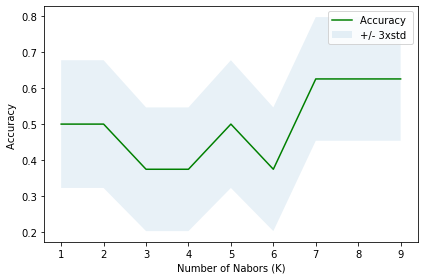

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
mean_f1_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    mean_f1_acc[n-1] = metrics.f1_score(y_test, yhat, average="weighted")
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [106]:
print( "The best accuracy (Jaccard) was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)
print("F1-Score Accuracy = " + str(mean_f1_acc.max()))

The best accuracy (Jaccard) was with 0.625 with k= 7
F1-Score Accuracy = 0.6428571428571428


In [107]:
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)

In [108]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['0', '1', '4', '1', '0'], dtype=object)

# Decision Tree

In [109]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [110]:
drugTree.fit(X_train,y_train)
predTree = drugTree.predict(X_test)

In [111]:
print(predTree)

['0' '1' '4' '0' '1' '0' '1' '1']


In [112]:
print("Decision Trees's Jaccard Accuracy: ", metrics.accuracy_score(y_test, predTree))
print("Decision Trees's F1-Score Accuracy: ", metrics.f1_score(y_test, predTree, average="weighted"))

Decision Trees's Jaccard Accuracy:  0.375
Decision Trees's F1-Score Accuracy:  0.38333333333333336


In [113]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

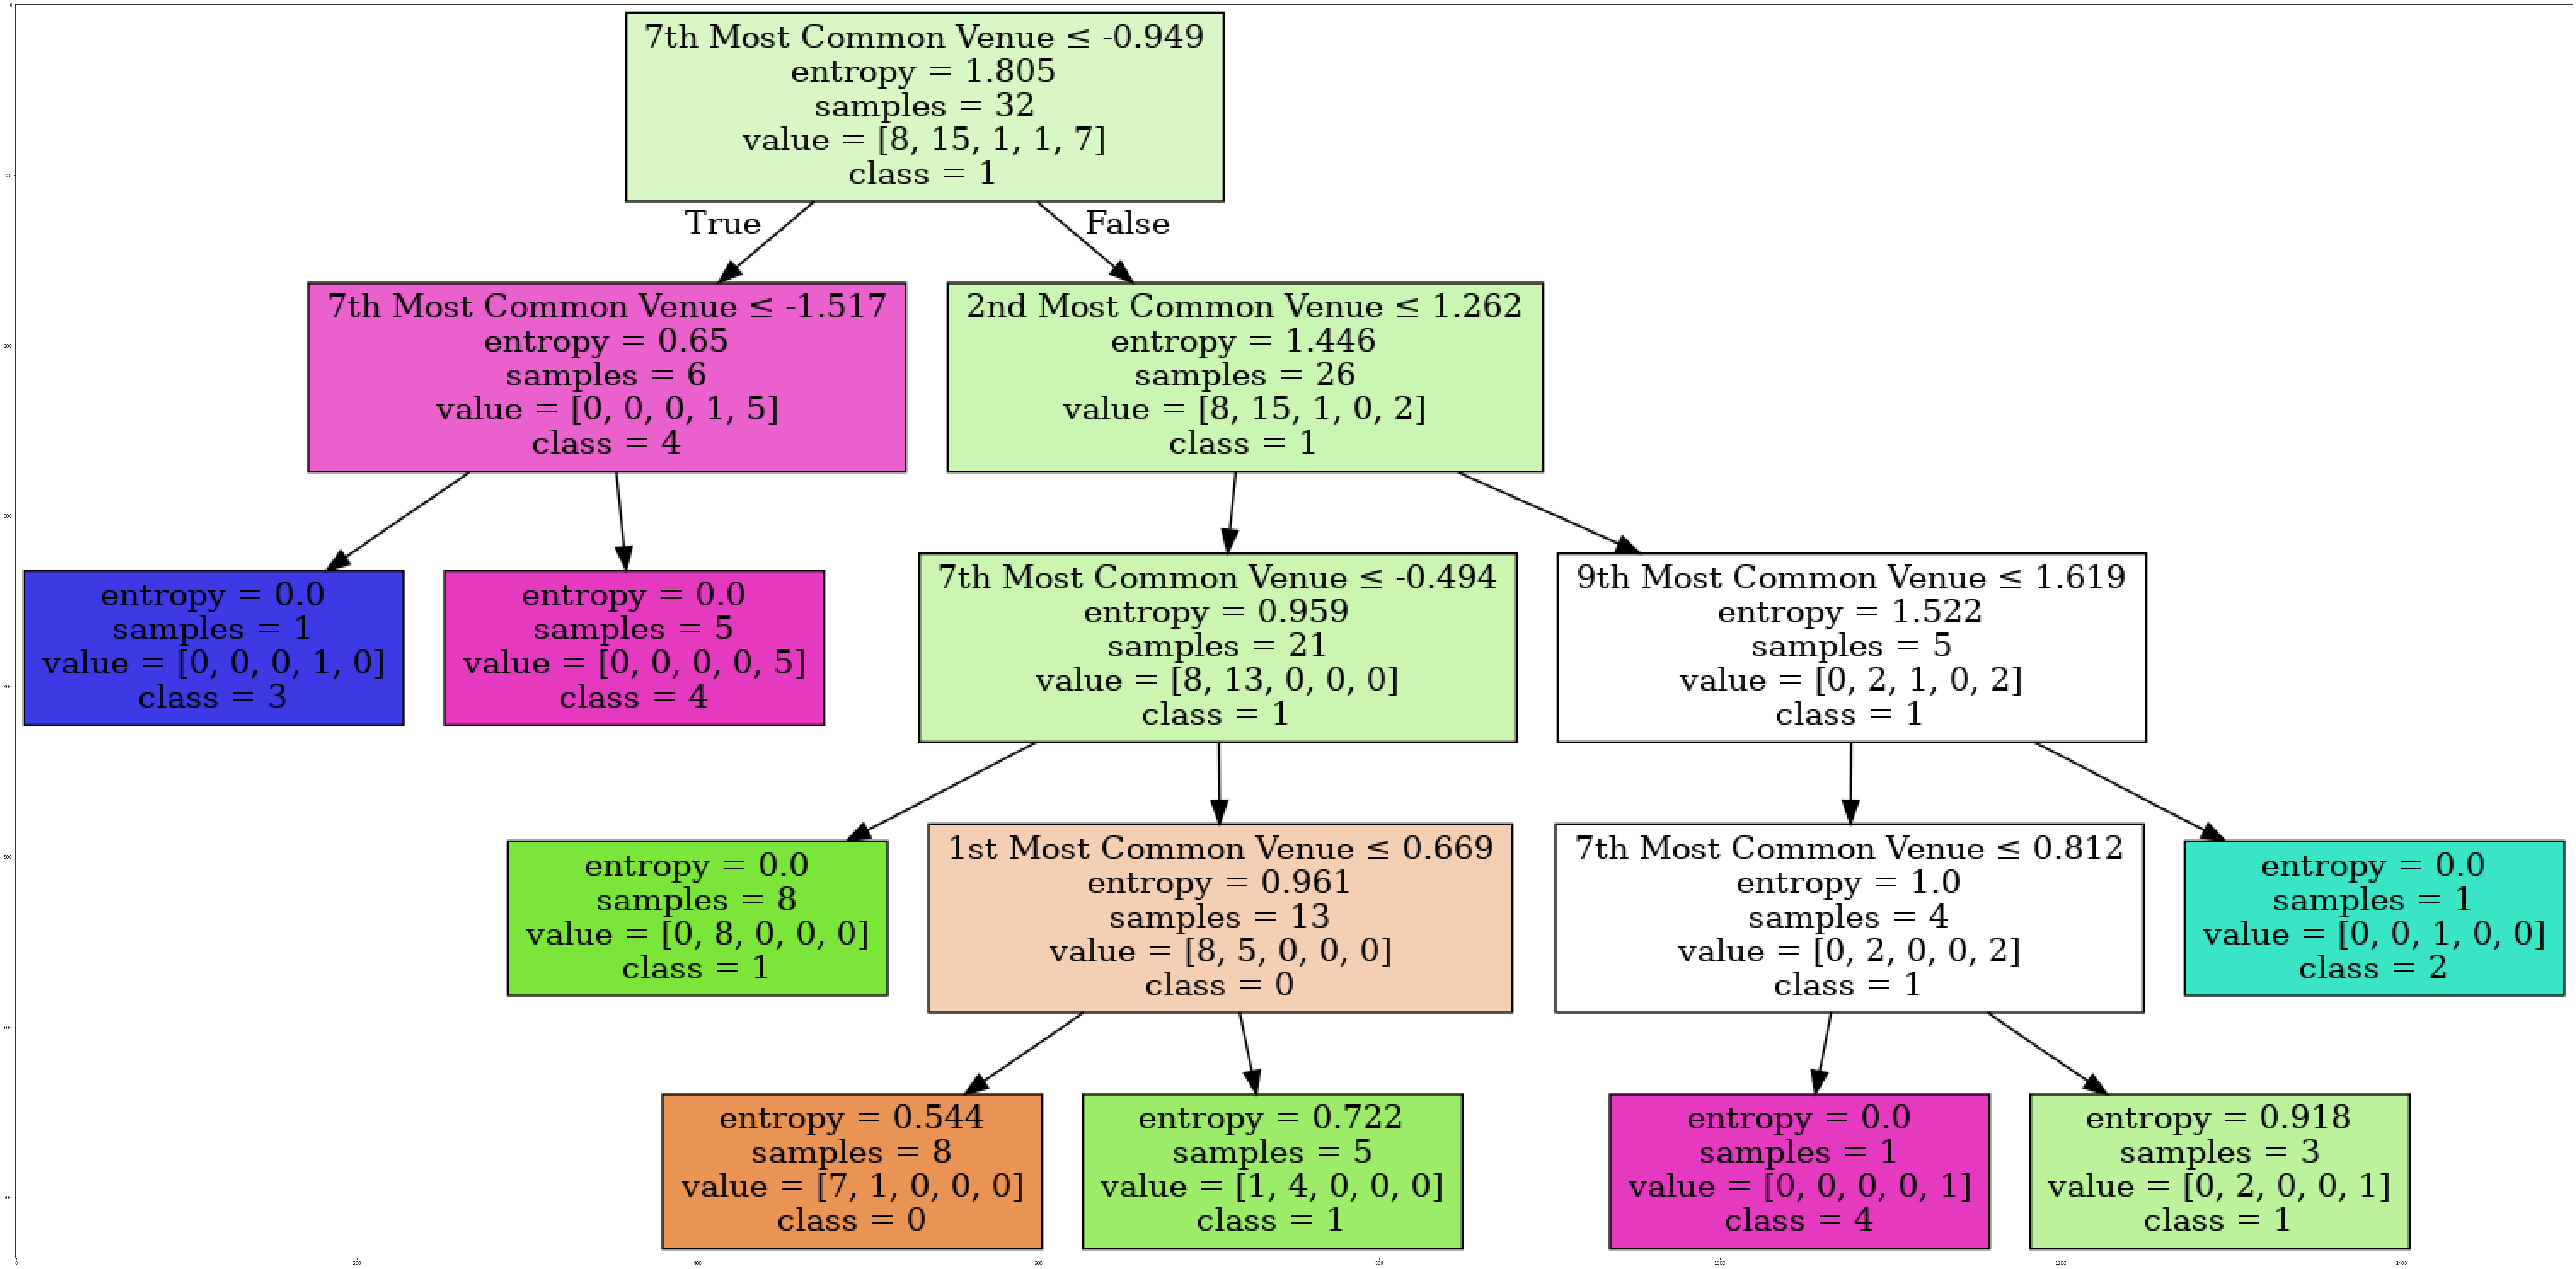

In [114]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = new_df.columns
targetNames = y.unique().tolist()
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [115]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [116]:
yhat = clf.predict(X_test)

In [117]:
print("SVM's Jaccard Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("SVM's F1-Score Accuracy: ", metrics.f1_score(y_test, yhat, average="weighted"))

SVM's Jaccard Accuracy:  0.625
SVM's F1-Score Accuracy:  0.625


# Logistic Regression

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [119]:
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
print(yhat_prob)

[[0.21986538 0.20653995 0.2019269  0.18967322 0.18199455]
 [0.21259035 0.21188938 0.20142302 0.18983357 0.18426368]
 [0.18189543 0.19720407 0.18296626 0.20728752 0.23064672]
 [0.19764347 0.2050304  0.19405951 0.19654878 0.20671785]
 [0.21179852 0.21392691 0.20009704 0.18820079 0.18597674]
 [0.20814246 0.19697913 0.19641605 0.19691002 0.20155234]
 [0.20375151 0.21083164 0.19758107 0.19387425 0.19396153]
 [0.18498292 0.19975785 0.18574063 0.20433905 0.22517954]]


In [96]:
print(yhat)

['0' '0' '4' '4' '1' '0' '1' '4']


In [120]:
from sklearn.metrics import jaccard_similarity_score, log_loss
print("Logistic Regression's Jaccard Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Logistic Regression's F1-Score Accuracy: ", metrics.f1_score(y_test, yhat, average="weighted"))
# print("Logistic Regression's LogLoss Accuracy: ", metrics.log_loss(y_test, yhat_prob))

Logistic Regression's Jaccard Accuracy:  0.625
Logistic Regression's F1-Score Accuracy:  0.6107142857142858


In [64]:
print(["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue", "6th Most Common Venue", "7th Most Common Venue", "8th Most Common Venue", "9th Most Common Venue", "10th Most Common Venue"])

['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue']


In [121]:
data = {"1st Most Common Venue":[8], "2nd Most Common Venue":[11], "3rd Most Common Venue":[11], "4th Most Common Venue":[11], "5th Most Common Venue":[12], "6th Most Common Venue":[1], 
        "7th Most Common Venue":[20], "8th Most Common Venue":[7], "9th Most Common Venue":[0], "10th Most Common Venue":[20]} 
  
# Create DataFrame 
test_df = pd.DataFrame(data) 

In [122]:
test_df

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8,11,11,11,12,1,20,7,0,20


In [123]:
candidate_cluster = neigh.predict(test_df)

In [124]:
candidate_cluster

array(['0'], dtype=object)

In [67]:
y_2 = drugTree.predict(test_df)

In [68]:
y_2

array(['0'], dtype=object)

In [127]:
cluster_1_df.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,10,10,10,10,10,10,10,10,10,10,10
unique,10,6,6,9,8,9,10,9,9,9,9
top,West Village,Park,Hotel,American Restaurant,Park,Coffee Shop,French Restaurant,Café,Coffee Shop,Italian Restaurant,Coffee Shop
freq,1,3,4,2,2,2,1,2,2,2,2


In [134]:
cluster_2_df.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,17,17,17,17,17,17,17,17,17,17,17
unique,17,6,12,14,17,14,13,12,15,15,14
top,Little Italy,Italian Restaurant,Coffee Shop,Pizza Place,Mexican Restaurant,Mediterranean Restaurant,Bakery,French Restaurant,Mediterranean Restaurant,Italian Restaurant,Japanese Restaurant
freq,1,7,3,3,1,2,3,4,2,2,2


In [135]:
cluster_3_df.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,Stuyvesant Town,Park,Playground,Heliport,Fountain,Farmers Market,Skating Rink,Bistro,Gas Station,Baseball Field,Gym / Fitness Center
freq,1,1,1,1,1,1,1,1,1,1,1


In [136]:
cluster_4_df.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1
top,Marble Hill,Gym,Coffee Shop,Yoga Studio,Diner,Seafood Restaurant,Sandwich Place,Supplement Shop,Tennis Stadium,Donut Shop,Shopping Mall
freq,1,1,1,1,1,1,1,1,1,1,1


In [137]:
cluster_5_df.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,11,11,11,11,11,11,11,11,11,11,11
unique,11,8,10,10,11,10,10,10,11,9,11
top,Inwood,Mexican Restaurant,Cocktail Bar,Deli / Bodega,Mexican Restaurant,Seafood Restaurant,Bakery,Spanish Restaurant,Mexican Restaurant,Coffee Shop,Scenic Lookout
freq,1,2,2,2,1,2,2,2,1,2,1
